In [60]:
import sys
sys.executable

# packages used
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
from rasterio.plot import show 
import plotly.graph_objects as go
import os
from shapely.geometry import Polygon, MultiPolygon

from rasterio.windows import from_bounds


In [10]:
# working directory
os.getcwd()

# path to data folder
data_pth = "../../../frontend/data/"


In [53]:
# county geometry 
counties_gdf = gpd.read_file(f"{data_pth}geometry_counties_all.geojson")
print(counties_gdf.crs)

EPSG:4326


In [54]:
r18 = rasterio.open(f"{data_pth}loc_2018.tif")
r22 = rasterio.open(f"{data_pth}loc_2019-2022.tif")
r23 = rasterio.open(f"{data_pth}loc_2023.tif")

counties_gdf = counties_gdf.to_crs(r18.crs)

print(r18.crs)
print(counties_gdf.crs)

EPSG:25831
PROJCS["ETRS89 / UTM zone 31N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222100887,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25831"]]


<Axes: >

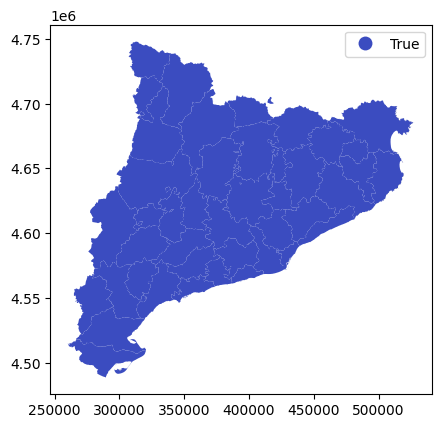

In [58]:

pixel_area = r18.res[0] * r18.res[1]  # e.g., 1 m × 1 m = 1 m²

# Compute county bounding box area in CRS units
counties_gdf["bbox_area"] = counties_gdf.geometry.bounds.apply(
    lambda row: (row.maxx - row.minx) * (row.maxy - row.miny), axis=1
)

# Estimate number of pixels (approx)
counties_gdf["n_pixels_est"] = counties_gdf["bbox_area"] / pixel_area

memory_limit_pixels = 50_000_000  # set a threshold you can handle in memory

counties_gdf["too_large"] = counties_gdf["n_pixels_est"] > memory_limit_pixels

counties_gdf.plot(column="too_large", cmap="coolwarm", legend=True)

In [63]:
def compute_county_transitions(counties_gdf, r18, r22, r23, downsample_factor=1):
    results = []

    for idx, row in counties_gdf.iterrows():
        county_id = row["county"]  
        geom = row["geometry"]

        # Ensure geometry is a list of polygons
        if isinstance(geom, Polygon):
            geoms = [geom]
        elif isinstance(geom, MultiPolygon):
            geoms = list(geom.geoms)
        else:
            raise TypeError(f"Unexpected geometry type: {type(geom)}")

        # Read each raster
        def read_and_downsample(raster):
            if downsample_factor == 1:
                arr, _ = mask(raster, geoms, crop=True)
                return arr[0]
            else:
                # Full raster, then resize
                arr, _ = mask(raster, geoms, crop=True)
                arr = arr[0]
                # Downsample using simple block mean (or just slice)
                new_shape = (arr.shape[0] // downsample_factor,
                             arr.shape[1] // downsample_factor)
                arr_small = arr[:new_shape[0]*downsample_factor, :new_shape[1]*downsample_factor]
                arr_small = arr_small.reshape(new_shape[0], downsample_factor,
                                              new_shape[1], downsample_factor).mean(axis=(1,3))
                return arr_small.astype(arr.dtype)

        arr18 = read_and_downsample(r18)
        arr22 = read_and_downsample(r22)
        arr23 = read_and_downsample(r23)

        # Identify valid pixels
        nodata = r18.nodata
        valid = (
            (arr18 != nodata) &
            (arr22 != nodata) &
            (arr23 != nodata)
        )

        # Compute transitions
        df = pd.DataFrame({
            "from_class": arr18[valid],
            "to_class": arr23[valid]
        })

        counts = df.value_counts().reset_index()
        counts.columns = ["from_class", "to_class", "count"]
        counts["county"] = county_id

        results.append(counts)

    transition_counts = pd.concat(results, ignore_index=True)
    return transition_counts

In [64]:
# Use factor=50 to downsample 50x in each dimension
transition_counts = compute_county_transitions(counties_gdf, r18, r22, r23, downsample_factor=50)

# Check results
print(transition_counts.head())

MemoryError: Unable to allocate 1.18 GiB for an array with shape (1, 30599, 41487) and data type uint8

In [32]:
print(luc_2023.crs)
print(luc_2023.res)
print(luc_2023.height, luc_2023.width)
print(luc_2023.width * luc_2023.height)

print(luc_2022.crs)
print(luc_2022.res)
print(luc_2022.height, luc_2022.width)
print(luc_2022.width * luc_2022.height)

print(luc_2018.crs)
print(luc_2018.res)
print(luc_2018.width * luc_2018.height)

EPSG:25831
(1.0, 1.0)
259198 267234
69266518332
EPSG:25831
(1.0, 1.0)
259198 267234
69266518332
EPSG:25831
(1.0, 1.0)
69266518332


In [43]:
with rasterio.open(f"{data_pth}loc_2023.tif") as src2023, \
     rasterio.open(f"{data_pth}loc_2019-2022.tif") as src2022:

    profile = src2023.profile
    profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

    out_path = f"{data_pth}land_use_change.tif"
    
    with rasterio.open(out_path, 'w', **profile) as dst:
        # process by block
        for ji, window in src2023.block_windows(1):
            arr_2023 = src2023.read(1, window=window)
            arr_2022 = src2022.read(1, window=window)
            
            change_block = (arr_2023 != arr_2022).astype(np.uint8)
            dst.write(change_block, 1, window=window)

In [27]:
# Open rasters
with rasterio.open(f"{data_pth}loc_2023.tif") as src2023, \
     rasterio.open(f"{data_pth}loc_2019-2022.tif") as src2022:

    # Downsample for memory safety
    factor = 100
    out_shape = (1, src2023.height // factor, src2023.width // factor)
    
    arr_2023 = src2023.read(1, out_shape=out_shape)
    arr_2022 = src2022.read(1, out_shape=out_shape)

# Flatten arrays
arr_2023_flat = arr_2023.flatten()
arr_2022_flat = arr_2022.flatten()

# Build transition counts
transition_df = pd.DataFrame({
    'from': arr_2022_flat,
    'to': arr_2023_flat
})

transition_counts = transition_df.value_counts().reset_index()
transition_counts.columns = ['from_class', 'to_class', 'count']

print(transition_counts.head())
print(len(transition_counts))
print(transition_counts['count'].sum())

   from_class  to_class    count
0           0         0  3714285
1           7         7   692841
2           1         1   583958
3          10        10   444126
4           9         9   268278
679
6923152


In [19]:
# Prepare nodes
all_classes = np.unique(np.concatenate([transition_counts['from_class'], transition_counts['to_class']]))
class_to_idx = {c: i for i, c in enumerate(all_classes)}

# Map source/target indices
source = transition_counts['from_class'].map(class_to_idx).astype(int).tolist()
target = transition_counts['to_class'].map(class_to_idx).astype(int).tolist()
value  = transition_counts['count'].astype(float).tolist()

print(source)
print(target)



[0, 7, 1, 10, 9, 8, 14, 5, 4, 18, 11, 3, 27, 13, 26, 15, 23, 25, 31, 22, 16, 12, 32, 24, 20, 21, 36, 38, 2, 29, 37, 28, 19, 40, 34, 39, 10, 1, 5, 7, 35, 7, 9, 10, 1, 6, 9, 14, 6, 17, 33, 6, 17, 30, 5, 17, 3, 17, 30, 1, 1, 6, 7, 5, 6, 7, 1, 8, 13, 14, 4, 20, 1, 10, 4, 8, 16, 10, 6, 14, 10, 14, 16, 32, 4, 7, 11, 1, 2, 13, 30, 30, 7, 26, 14, 16, 30, 9, 10, 1, 3, 8, 10, 10, 11, 8, 14, 7, 1, 1, 26, 14, 30, 32, 14, 8, 10, 19, 7, 17, 8, 5, 11, 15, 5, 30, 27, 8, 38, 8, 10, 41, 10, 5, 10, 5, 1, 30, 19, 20, 16, 9, 10, 13, 8, 8, 6, 26, 10, 10, 7, 14, 30, 30, 3, 6, 10, 5, 10, 14, 16, 27, 32, 10, 18, 11, 22, 14, 0, 1, 10, 10, 17, 9, 14, 29, 14, 14, 14, 3, 5, 16, 1, 16, 7, 17, 16, 26, 15, 9, 26, 30, 2, 38, 16, 7, 11, 14, 38, 4, 32, 29, 1, 12, 10, 30, 1, 32, 4, 1, 1, 6, 37, 32, 11, 7, 15, 20, 5, 3, 7, 3, 26, 32, 6, 1, 4, 6, 5, 28, 16, 17, 14, 15, 27, 14, 10, 1, 16, 2, 9, 12, 4, 7, 14, 14, 1, 7, 32, 27, 20, 26, 29, 14, 5, 26, 9, 32, 15, 7, 10, 27, 9, 29, 13, 13, 26, 7, 30, 16, 18, 30, 14, 26, 9, 8, 16

,from_class,to_class,count


In [ ]:
# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=[str(c) for c in all_classes]
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title_text="Land Cover Change 2022 → 2023", font_size=10)
fig.show()